# Convolutional Neural Net (CNN) Fraud Classifier

---
#### Note on the data set 
The data set used here (https://www.kaggle.com/datasets/ealaxi/banksim1) is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

age_i = ft.FeatureIndex('age_one_hot', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_one_hot', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_one_hot', ft.FEATURE_TYPE_INT_8, merchant)
category_i = ft.FeatureIndex('category_one_hot', ft.FEATURE_TYPE_INT_8, category)

customer_merchant = ft.FeatureConcat('MC_con', ft.FEATURE_TYPE_STRING, customer, merchant)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])


raw_features = ft.TensorDefinition('Raw', [
    date_time,
    amount,
    customer,
    age,
    gender, 
    merchant,
    category,
    customer_merchant,
    fraud
])

with en.EnginePandasNumpy(num_threads=2) as e:
    df_raw = e.from_csv(raw_features, file, inference=False)

df_raw

2022-07-17 09:46:07.313 d373c7.engines.common          INFO     Start Engine...
2022-07-17 09:46:07.314 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-07-17 09:46:07.314 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-07-17 09:46:07.314 d373c7.engines.panda_numpy     INFO     Building Panda for : Raw from file ../../../../data/bs140513_032310.csv
2022-07-17 09:46:07.523 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-07-17 09:46:07.523 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-07-17 09:46:07.530 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 8)
2022-07-17 09:46:07.985 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-07-17 09:46:08.008 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Raw


,date,amount,customer,age,gender,merchant,category,MC_con,fraud
0,2020-01-01,4.55,C1093826151,4,M,M348934600,es_transportation,C1093826151M348934600,0
1,2020-01-01,39.68,C352968107,2,M,M348934600,es_transportation,C352968107M348934600,0
2,2020-01-01,26.89,C2054744914,4,F,M1823072687,es_transportation,C2054744914M1823072687,0
3,2020-01-01,17.25,C1760612790,3,M,M348934600,es_transportation,C1760612790M348934600,0
4,2020-01-01,35.72,C757503768,5,M,M348934600,es_transportation,C757503768M348934600,0
...,...,...,...,...,...,...,...,...,...
594638,2020-06-28,20.53,C1753498738,3,F,M1823072687,es_transportation,C1753498738M1823072687,0
594639,2020-06-28,50.73,C650108285,4,F,M1823072687,es_transportation,C650108285M1823072687,0
594640,2020-06-28,22.44,C123623130,2,F,M349281107,es_fashion,C123623130M349281107,0
594641,2020-06-28,14.46,C1499363341,5,M,M1823072687,es_transportation,C1499363341M1823072687,0


In [5]:
# This feature will return the 10 day sum of the amount, for the customer
amount_cust_10d_sum = ft.FeatureGrouper(
    'amount_cust_10d_sum',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer,                            # Group over customer
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_SUM                    # Take the sum over the period elements.
)
# This feature will return the 10 day max of the amount, for the customer
amount_cust_10d_cnt = ft.FeatureGrouper(
    'amount_cust_10d_cnt',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer,                            # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_COUNT                  # Take the count over the period elements.
)
# This feature will return the 10 day maximum of the amount, for the customer
amount_cust_10d_max = ft.FeatureGrouper(
    'amount_cust_10d_max',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer,                            # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_MAX                    # Take the max over the period elements.
)

# This feature will return the 10 day average of the amount, for the customer
amount_cust_10d_avg = ft.FeatureGrouper(
    'amount_cust_10d_avg',               # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer,                            # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_AVG                    # Take the average over the period elements.
)

# This feature will return the 10 day sum of the amount, for the customer-merchant relation
amount_cust_merch_10d_sum = ft.FeatureGrouper(
    'amount_cust_merc_10d_sum',          # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer_merchant,                   # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_SUM                    # Take the sum over the period elements.
)

# This feature will return the 10 day count of the amount, for the customer-merchant relation
amount_cust_merch_10d_cnt = ft.FeatureGrouper(
    'amount_cust_merc_10d_count',        # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer_merchant,                   # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_COUNT                  # Take the count over the period elements.
)


# This feature will return the 10 day max of the amount, for the customer-merchant relation
amount_cust_merch_10d_max = ft.FeatureGrouper(
    'amount_cust_merc_10d_max',          # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer_merchant,                   # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_MAX                    # Take the max over the period elements.
)

# This feature will return the 10 day average of the amount, for the customer-merchant relation
amount_cust_merch_10d_avg = ft.FeatureGrouper(
    'amount_cust_merc_10d_avg',          # Name of the feature
    ft.FEATURE_TYPE_FLOAT_32,            # Make the feature a type float
    amount,                              # Aggregate the amount
    customer_merchant,                   # Group over customer/merchant
    None,
    ft.TIME_PERIOD_DAY,                  # Make the period element a day
    10,                                  # Aggregate 10 days
    ft.AGGREGATOR_AVG                    # Take the average over the period elements.
)

amount_cust_10d_sum_scale = ft.FeatureNormalizeScale(
    'amount_cust_10d_sum_scale', 
    ft.FEATURE_TYPE_FLOAT_32, 
    amount_cust_10d_sum
)

amount_cust_10d_cnt_scale = ft.FeatureNormalizeScale(
    'amount_cust_10d_cnt_scale', 
    ft.FEATURE_TYPE_FLOAT_32, 
    amount_cust_10d_cnt
)

amount_cust_10d_max_scale = ft.FeatureNormalizeScale(
    'amount_cust_10d_max_scale', 
    ft.FEATURE_TYPE_FLOAT_32, 
    amount_cust_10d_max
)

amount_cust_10d_avg_scale = ft.FeatureNormalizeScale(
    'amount_cust_10d_avg_scale', 
    ft.FEATURE_TYPE_FLOAT_32, 
    amount_cust_10d_avg
)

amount_cust_merch_10d_sum_scale = ft.FeatureNormalizeScale(
    'amount_cust_merch_10d_sum_scale', 
    ft.FEATURE_TYPE_FLOAT_32, 
    amount_cust_merch_10d_sum
)

amount_cust_merch_10d_cnt_scale = ft.FeatureNormalizeScale(
    'amount_cust_merch_10d_cnt_scale', 
    ft.FEATURE_TYPE_FLOAT_32, 
    amount_cust_merch_10d_cnt
)

amount_cust_merch_10d_max_scale = ft.FeatureNormalizeScale(
    'amount_cust_merch_10d_max_scale', 
    ft.FEATURE_TYPE_FLOAT_32, 
    amount_cust_merch_10d_max
)

amount_cust_merch_10d_avg_scale = ft.FeatureNormalizeScale(
    'amount_cust_merch_10d_avg_scale', 
    ft.FEATURE_TYPE_FLOAT_32, 
    amount_cust_merch_10d_avg
)

freq_features = ft.TensorDefinition(
    'learning', 
    [
        amount_cust_10d_sum_scale,
        amount_cust_10d_cnt_scale,
        amount_cust_10d_max_scale,
        amount_cust_10d_avg_scale,
        amount_cust_merch_10d_sum_scale,
        amount_cust_merch_10d_cnt_scale,
        amount_cust_merch_10d_max_scale,
        amount_cust_merch_10d_avg_scale
    ])

ref_features = ft.TensorDefinition('ref_features', [
    age_i,
    gender_i,
    category_i,
    merchant_i
])


label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([freq_features, ref_features, label])

with en.EnginePandasNumpy(num_threads=1) as e:
    ref_df = e.from_csv(ref_features, file, inference=False)
    ref_np = e.to_numpy_list(ref_features, ref_df) 
    ser_np = e.to_series_frequencies(freq_features, file, time_feature=date_time, inference=False)
    lb_df = e.from_csv(label, file, inference=False)
    lb_np = e.to_numpy_list(label, lb_df)
    data_list = en.NumpyList(ser_np.lists + ref_np.lists + lb_np.lists)

2022-07-17 09:46:09.502 d373c7.engines.common          INFO     Start Engine...
2022-07-17 09:46:09.502 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2022-07-17 09:46:09.502 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2022-07-17 09:46:09.503 d373c7.engines.panda_numpy     INFO     Building Panda for : ref_features from file ../../../../data/bs140513_032310.csv
2022-07-17 09:46:09.666 d373c7.engines.panda_numpy     INFO     Building Panda for : <Built Features> from DataFrame. Inference mode <False>
2022-07-17 09:46:09.666 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-07-17 09:46:09.667 d373c7.engines.panda_numpy     INFO     Done creating Built Features. Shape=(594643, 4)
2022-07-17 09:46:09.686 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Built Features
2022-07-17 09:46:09.689 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: ref_features
2022-07-17 09:46:09.690 d373c7.engines.pa

## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [6]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list, ser_np, lb_np, lb_df
gc.collect()
print('Done')

Training Data shapes [(434643, 10, 8), (434643, 4), (434643,)]
Validation Data shapes [(30000, 10, 8), (30000, 4), (30000,)]
Test Data shapes [(100000, 10, 8), (100000, 4), (100000,)]
Done


## Set-up Devices

In [7]:
device, cpu = pt.init_devices()

2022-07-17 09:46:14.730 d373c7.pytorch.common          INFO     Torch Version : 1.11.0+cu113
2022-07-17 09:46:14.794 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2022-07-17 09:46:14.794 d373c7.pytorch.common          INFO     Cuda Version  : 11.3


## Build the model

> In this example we still use a `GeneratedClassifier` model. We give it the TensorDefinitionMulti object containing our various tensor definitions. As there is now TensorDefinition that has 3D data (our transaction series; which has Batch x Series x Feature shape), the model will use a layer capable of handling 3D Tensors. We ask it to use *16* recurrent features and add 1 layer of *8* linear features after that.

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)
train_sampler = pt.ClassSamplerMulti(model_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

d = pm.ClassifierDefaults()
d.convolutional_dense = False

# Create a Model
m = pm.GeneratedClassifier(model_features, c_defaults=d, convolutional_layers=[(8, 2, 1), (16, 2, 1)], attention_heads=1, linear_layers=[16])

print(m)

GeneratedClassifier(
  Number of parameters : 4636. Loss : SingleLabelBCELoss,  mean
  (streams): ModuleList(
    (0): Sequential(
      (learning): TensorDefinitionHead(lcs=['Continuous'])
      (Convolutional): ConvolutionalBody1d(
        (conv_layers): Sequential(
          (conv_01): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
          (relu_01): ReLU()
          (conv_02): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
          (relu_02): ReLU()
          (norm_02): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TensorDefinitionHead(
      lcs=['Categorical']
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(9, 4)
          (1): Embedding(5, 4)
          (2): Embedding(16, 7)
          (3): Embedding(51, 25)
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (tail): TailBinary(
    (layers): Sequent

In a diagram form the model look like this. The series go into a convolutional layer. They get condensed to a 16 (last layer # filters) x 8 (10 freq length, -2 for each conv layer reduction).

The referential info goes into an embedding, the embeddings output a total of 40 features. Everything gets concatenated an then fed to a last set of linear layers.

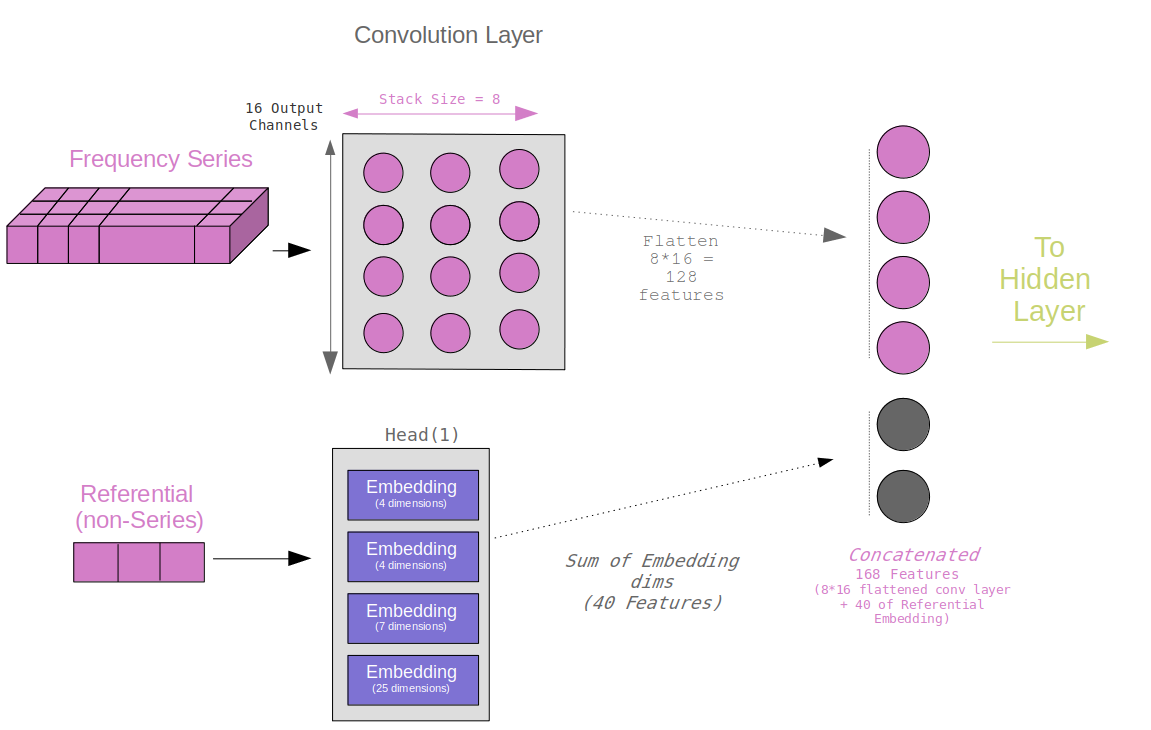

# Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2022-07-17 09:48:38.372 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 263.79it/s]
2022-07-17 09:48:41.983 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


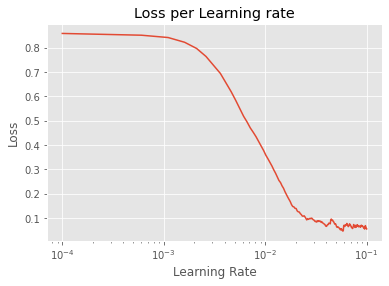

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 010/010: 100%|██████████| 3631/3631 [00:09<00:00, 373.20it/s, train_loss=0.0319, train_acc=0.99, val_loss=0.0241, val_acc=0.991]


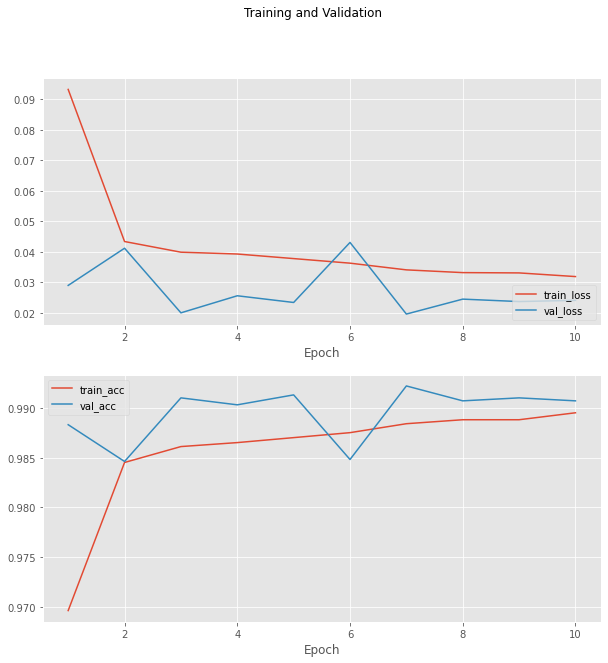

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. We can see that this model performs quite well. It's one of the better performing models thus far. But maybe that should not be a surprise, this is seeing a lot of information on the customers recent history as well as referential information on the current payment.

Testing in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 863.56it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     98926
         1.0       0.57      0.98      0.72      1074

    accuracy                           0.99    100000
   macro avg       0.79      0.99      0.86    100000
weighted avg       1.00      0.99      0.99    100000


auc score : 0.9994
ap score  : 0.9653
-----------------------------------------------------


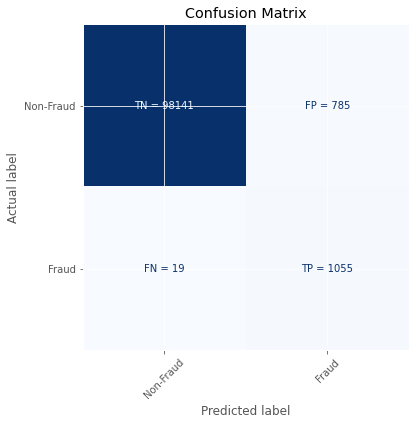

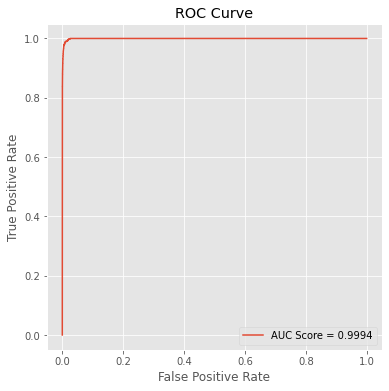

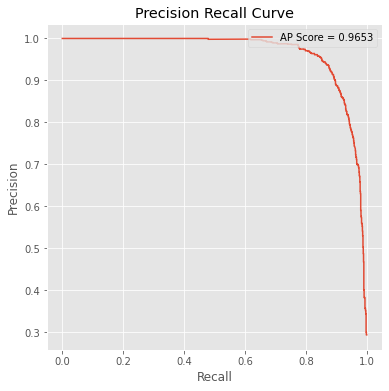

In [11]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))